In [1]:
movie <- read.csv("E:/Machine Learning/Datasets/Movie_regression.csv", header = TRUE)
dim(movie)

[1] 506  18

In [2]:
summary(movie)

 Marketing.expense Production.expense Multiplex.coverage     Budget     
 Min.   :  20.13   Min.   : 55.92     Min.   :0.1290     Min.   :19781  
 1st Qu.:  21.64   1st Qu.: 65.38     1st Qu.:0.3760     1st Qu.:32694  
 Median :  25.13   Median : 74.38     Median :0.4620     Median :34488  
 Mean   :  92.27   Mean   : 77.27     Mean   :0.4453     Mean   :34911  
 3rd Qu.:  93.54   3rd Qu.: 91.20     3rd Qu.:0.5510     3rd Qu.:36794  
 Max.   :1799.52   Max.   :110.48     Max.   :0.6150     Max.   :48773  
                                                                        
  Movie_length   Lead_.Actor_Rating Lead_Actress_rating Director_rating
 Min.   : 76.4   Min.   :3.840      Min.   :4.035       Min.   :3.840  
 1st Qu.:118.5   1st Qu.:7.316      1st Qu.:7.504       1st Qu.:7.296  
 Median :151.0   Median :8.307      Median :8.495       Median :8.312  
 Mean   :142.1   Mean   :8.014      Mean   :8.186       Mean   :8.020  
 3rd Qu.:167.6   3rd Qu.:8.865      3rd Qu.:9.030       

In [3]:
# The Time_taken variable has missing values. So we do missing value imputation
movie$Time_taken[is.na(movie$Time_taken)] <- mean(movie$Time_taken, na.rm=TRUE)
sum(is.na(movie))

[1] 0

# Test-Train Split

In [4]:
library(caTools)
set.seed(0)
split <- sample.split(movie,SplitRatio = 0.8)
train <- subset(movie, split==TRUE)
test <- subset(movie, split==FALSE)

In [5]:
dim(train)
dim(test)

[1] 393  18

[1] 113  18

# Decision Tree


Regression tree:
rpart(formula = Collection ~ ., data = train, control = rpart.control(maxdepth = 8))

Variables actually used in tree construction:
[1] Budget            Director_rating   Marketing.expense Trailer_views    

Root node error: 1.3086e+11/393 = 332989821

n= 393 

        CP nsplit rel error  xerror     xstd
1 0.435077      0   1.00000 1.00437 0.095689
2 0.156588      1   0.56492 0.61086 0.070385
3 0.090647      2   0.40834 0.45315 0.058600
4 0.048872      3   0.31769 0.34382 0.050577
5 0.031052      4   0.26882 0.38878 0.056458
6 0.021724      5   0.23776 0.32729 0.047242
7 0.014585      6   0.21604 0.31481 0.048867
8 0.010000      7   0.20146 0.31447 0.048818


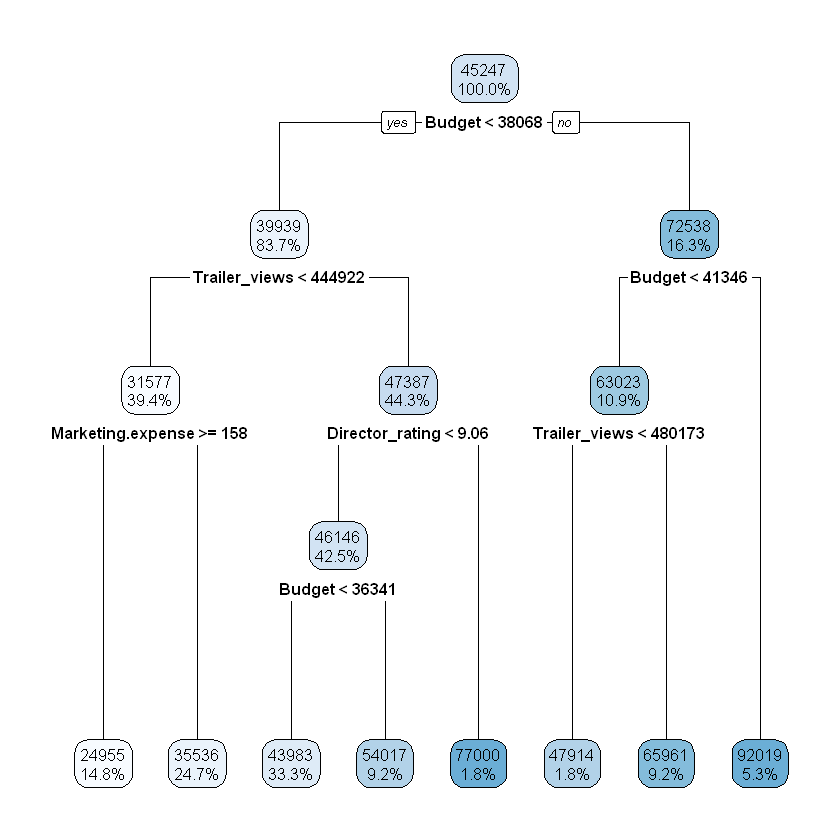

In [6]:
library(rpart)
library(rpart.plot)

regtree <- rpart(Collection~., data=train, control=rpart.control(maxdepth = 8))
rpart.plot(regtree, digits=-3)
printcp(regtree)

In [8]:
# Predicting values on test set
test$regtree <- predict(regtree, test, type="vector")
MSEregtree <- mean((test$regtree - test$Collection)^2)
MSEregtree

[1] 97922424

# Full Tree


Regression tree:
rpart(formula = Collection ~ ., data = train, control = rpart.control(cp = 0))

Variables actually used in tree construction:
 [1] Avg_age_actors      Budget              Critic_rating      
 [4] Director_rating     Genre               Lead_.Actor_Rating 
 [7] Lead_Actress_rating Marketing.expense   Movie_length       
[10] Multiplex.coverage  Production.expense  Time_taken         
[13] Trailer_views       Twitter_hastags     X3D_available      

Root node error: 1.3086e+11/393 = 332989821

n= 393 

           CP nsplit rel error  xerror     xstd
1  0.43507653      0   1.00000 1.00273 0.095500
2  0.15658756      1   0.56492 0.58950 0.066680
3  0.09064716      2   0.40834 0.43374 0.054116
4  0.04887218      3   0.31769 0.34122 0.048513
5  0.03105207      4   0.26882 0.36855 0.053490
6  0.02172378      5   0.23776 0.30922 0.046400
7  0.01458513      6   0.21604 0.27922 0.042112
8  0.00977123      7   0.20146 0.28362 0.041988
9  0.00935818      8   0.19168 0.28225 0.041

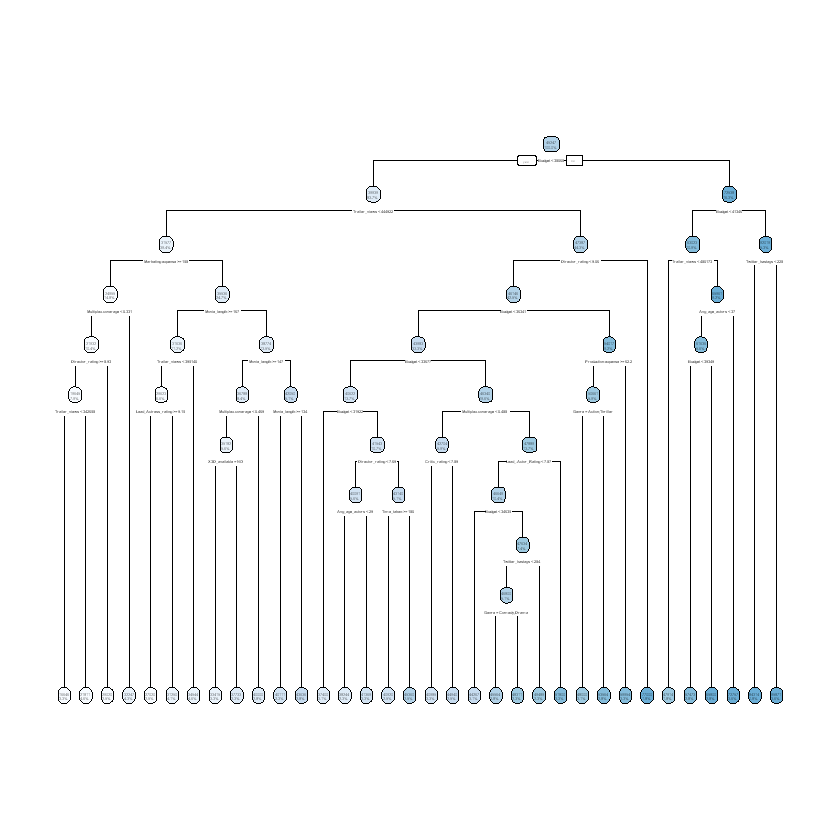

In [9]:
fulltree <- rpart(Collection~., data=train, control=rpart.control(cp=0))
rpart.plot(fulltree, digits=-3)
printcp(fulltree)

In [10]:
mincp <- regtree$cptable[which.min(regtree$cptable[,"xerror"]), "CP"]
mincp

[1] 0.01

In [11]:
test$fulltree <- predict(fulltree, test, type="vector")
MSEfull <- mean((test$fulltree - test$Collection)^2)
MSEfull

[1] 99037642

# Pruned Tree

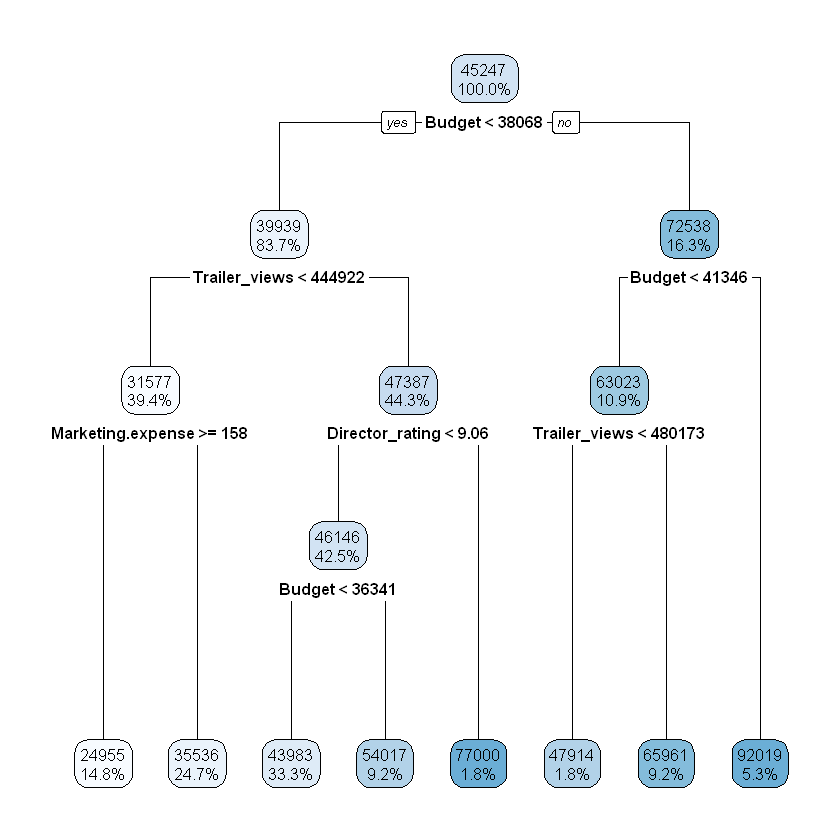

In [12]:
prunedtree<-prune(fulltree, cp= mincp )
rpart.plot(prunedtree, digits=-3)

In [13]:
test$pruned <- predict(prunedtree, test, type="vector")
MSE2pruned <- mean((test$pruned - test$Collection)^2)
MSE2pruned

[1] 97922424

# Bagging

In [14]:
library(randomForest)
set.seed(0)
bagging <- randomForest(Collection~., data=train, mtry=17)
test$bagging <- predict(bagging, test)
MSEbagging <- mean((test$bagging - test$Collection)^2)
MSEbagging

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.



[1] 52304350

# Random Forest

In [15]:
randomforest <- randomForest(Collection~., data=train, ntree=500)
test$randomforest <- predict(randomforest, test)
MSErandomforest <- mean((test$randomforest - test$Collection)^2)
MSErandomforest

[1] 43504108

# Gradient Boost

In [16]:
library(gbm)
set.seed(0)

# First we convert X3D_available and Genre variables into factors
train$X3D_available <- as.factor(train$X3D_available)
train$Genre <- as.factor(train$Genre)

gradient <- gbm(Collection~., data=train, distribution="gaussian", n.trees=5000, interaction.depth=4, shrinkage=0.2, verbose = F)
test$gradient <- predict(gradient, test, n.trees=5000)
MSEgradient <- mean((test$gradient-test$Collection)^2)
MSEgradient

Loaded gbm 2.1.8.1

Warning message in predict.gbm(gradient, test, n.trees = 5000):
"NAs introduced by coercion"


[1] 56865783

# Support Vector Machines

In [17]:
library (e1071)
svmfit = svm(Collection~., data=train , kernel = "linear", cost =0.01, scale = TRUE )
summary (svmfit)


Call:
svm(formula = Collection ~ ., data = train, kernel = "linear", cost = 0.01, 
    scale = TRUE)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  linear 
       cost:  0.01 
      gamma:  0.05 
    epsilon:  0.1 


Number of Support Vectors:  316






In [18]:
## Predicting on test set
test$svm = predict (svmfit ,test)
MSEsvm <- mean((test$svm-test$Collection)^2)
MSEsvm

[1] 102267174

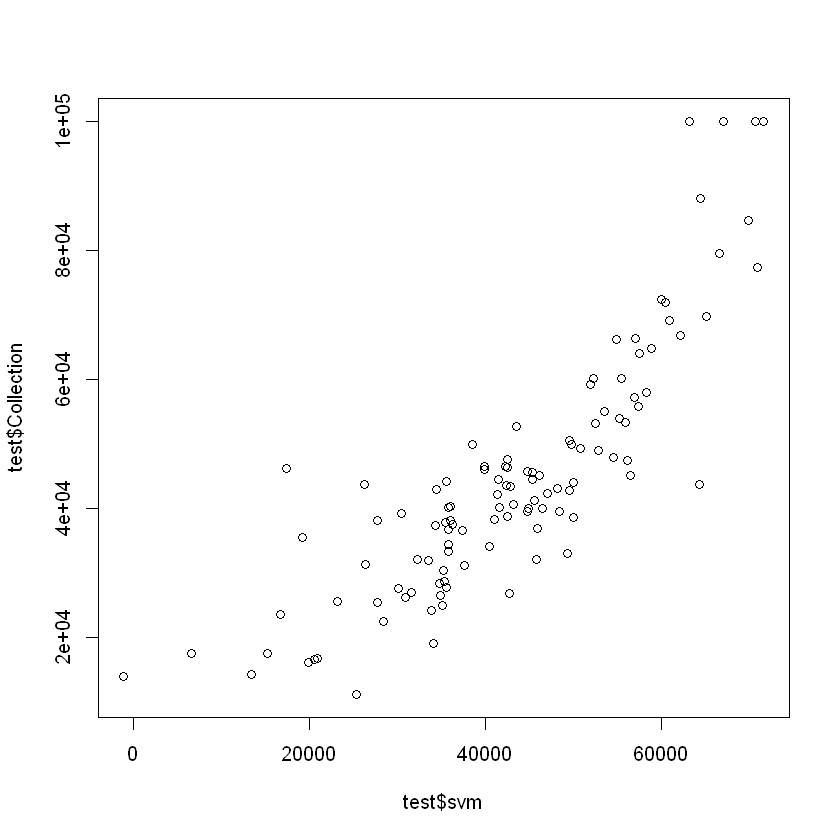

In [19]:
plot(test$svm,test$Collection)

# Conclusion

The Random Forest model provides the least mean squared error rate as 43 Million on the test set. Hence, this model is the best for predicting the box office collection

In [19]:
View(test)

,Marketing.expense,Production.expense,Multiplex.coverage,Budget,Movie_length,Lead_.Actor_Rating,Lead_Actress_rating,Director_rating,Producer_rating,Critic_rating,⋯,Avg_age_actors,Num_multiplex,Collection,regtree,fulltree,pruned,bagging,randomforest,gradient,svm
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20.1264,59.62,0.462,36524.12,138.7,7.825,8.095,7.910,7.995,7.94,⋯,23,494,48000,54016.67,59953.85,54016.67,53936.22,55897.48,50613.78,54581.61
5,21.3810,59.36,0.542,39701.58,127.7,6.920,7.070,6.815,7.070,8.26,⋯,55,395,72400,65961.11,72757.14,65961.11,70762.30,68534.57,72319.41,59983.30
7,21.7658,70.74,0.476,33396.66,140.1,7.065,7.265,7.150,7.400,8.96,⋯,41,522,45800,43983.21,41369.23,43983.21,39609.41,40542.90,41556.93,44810.35
8,22.8910,70.74,0.476,34285.46,169.6,6.980,7.075,6.875,7.170,7.96,⋯,56,571,44200,35536.08,34544.44,35536.08,36053.79,35743.15,36756.71,35588.30
19,36.0542,71.28,0.462,30308.08,110.1,8.100,8.240,8.070,8.000,6.80,⋯,41,543,40400,43983.21,37400.00,43983.21,39103.39,39836.95,40141.98,36061.35
23,44.6494,71.28,0.462,34118.81,165.2,7.910,8.010,7.845,8.275,6.80,⋯,48,575,30400,35536.08,37733.33,35536.08,32060.67,32735.63,32004.69,35238.18
25,35.0052,71.28,0.462,32907.82,167.6,7.655,7.965,7.640,7.940,7.80,⋯,27,502,31200,35536.08,34544.44,35536.08,32592.57,34006.13,33140.29,37654.17
26,36.8108,71.28,0.462,31102.44,159.2,7.655,7.835,7.640,7.960,7.80,⋯,35,516,27800,35536.08,37733.33,35536.08,34331.47,34776.65,31660.26,35619.94
37,21.9488,66.92,0.501,32446.76,134.9,8.305,8.360,8.190,8.390,8.16,⋯,39,454,40000,43983.21,45360.00,43983.21,42321.79,44576.90,47711.34,44859.65
